In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
import sys
sys.path.append('..')

In [4]:
# Human Tonsil snRNAseq from SlideTags
# https://www.nature.com/articles/s41586-023-06837-4

adata = sc.read_h5ad('/Users/koush/Downloads/slidetags_human_tonsil/human_tonsil.h5ad')
adata = adata[:, [gene for gene in adata.var_names if not bool(re.search(r'\.\d+$', gene))]]
adata

View of AnnData object with n_obs × n_vars = 5778 × 19171
    obs: 'cell_type'
    obsm: 'spatial'

In [5]:
# del adata.uns

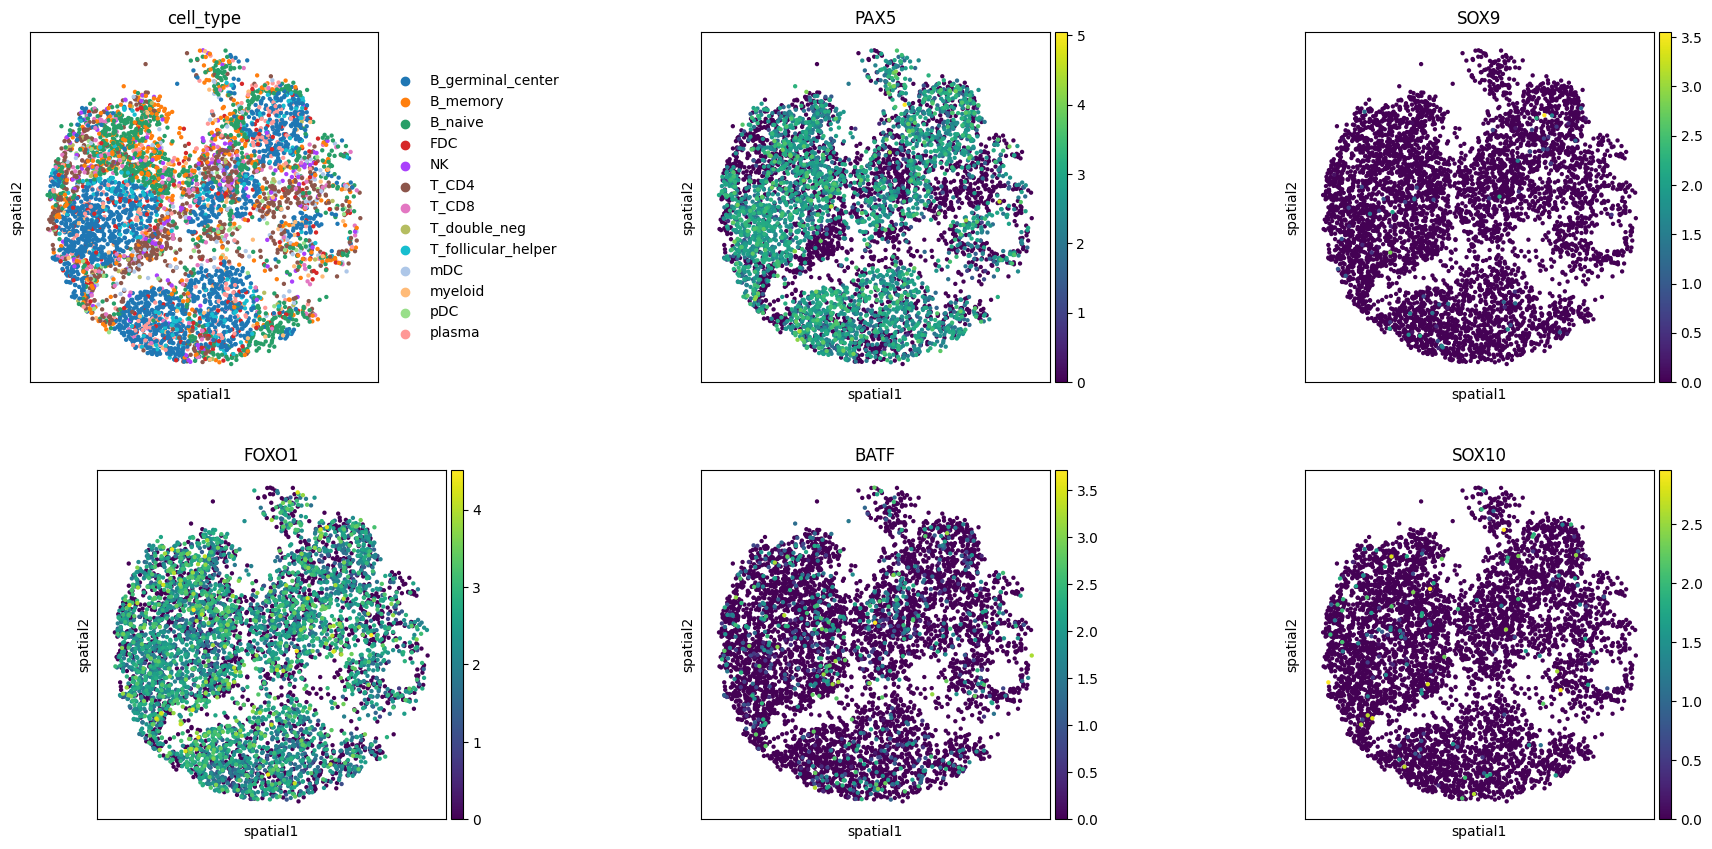

In [8]:
sc.pl.spatial(adata, color=['cell_type', 'PAX5', 'SOX9', 'FOXO1', 'BATF', 'SOX10'], ncols=3, spot_size=40)

In [7]:
adata.obs['cell_type'].value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [8]:
import os, sys 
sys.path.append('../../src')

In [9]:
import celloracle as co
base_GRN = co.data.load_human_promoter_base_GRN()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [10]:
from spaceoracle.tools.network import expand_paired_interactions
import commot as ct

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

ilr2_df =df_ligrec.query('receptor.str.contains("IL2") or ligand.str.contains("IL2")')
genes_of_interest = list(np.unique(ilr2_df.ligand.unique().tolist() + \
                         ilr2_df.receptor.unique().tolist()))
# len(genes_of_interest)
genes_of_interest = genes_of_interest + \
    ['FOXO1', 'BATF', 'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'SATB1', 'ID2', 'PAX5', 
    'CXCR4', 'CD83', 'CD86', 'AICDA', 'BCL2A1', 'BCL2', 'LMO2', 'CXCL13', 
    'CD80', 'TRAF3', 'CCL19', 'CCR7', 'CCL21']
len(genes_of_interest)

51

In [11]:
extra_genes = ['PAX5', 'IL2RA', 'IL2', 'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'FOXO1']

In [12]:
df = base_GRN[['gene_short_name']+list(np.intersect1d(base_GRN.columns, genes_of_interest))]

In [13]:
df.set_index('gene_short_name', inplace=True)

In [14]:
df.loc[df.sum(1) > 3, :].index

Index(['HPS1', 'CUTC', 'DNMBP', 'CPN1', 'LZTS2', 'LZTS2', 'SFXN3', 'MIR3158-2',
       'FBXW4', 'ARMH3',
       ...
       'MIR6089', 'CD99', 'ZFY', 'TGIF2LY', 'PCDH11Y', 'SHOX', 'SPRY3',
       'WASIR1', 'DDX11L16', 'LINC00279'],
      dtype='object', name='gene_short_name', length=5815)

In [15]:
genes_of_interest = genes_of_interest + list(df.loc[df.sum(1) >5, :].index)

In [16]:
len(genes_of_interest)

435

In [17]:
n_top_genes = 3000
min_cells = 46
min_counts = 200

In [18]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_MT"] < 20].copy()
adata = adata[:, ~adata.var["MT"]]

sc.pp.filter_genes(adata, min_cells=min_cells)
# adata.layers["raw_count"] = adata.X.copy()
# sc.pp.normalize_total(adata, inplace=True)
# sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(genes_of_interest))]

adata.layers["normalized_count"] = adata.to_df().values.copy()
adata

AnnData object with n_obs × n_vars = 5778 × 3163
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [19]:
'PAX5' in adata.var_names

True

In [20]:
adata.layers["normalized_count"].min(), adata.layers["normalized_count"].max()

(0.0, 8.8678228953803)

In [21]:
adata.X.min(), adata.X.max()

(0.0, 8.8678228953803)

In [22]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

In [23]:
adata.obs['cell_type'].value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [24]:
adata.obs['cell_type_int'] = pd.Categorical(adata.obs['cell_type']).codes

In [25]:
adata.write_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')

In [17]:
import scanpy as sc 
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 5000
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'cell_type_int'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [20]:
'IL2RA' in adata.var_names


True